## NCEP3 Example

The Goddard Satellite-based Surface Turbulent Fluxes (GSSTF) Version 3 Dataset is a product of the NASA MEaSURES project. The dataset consists of 7,850 files in the HDF-EOS5 format. Each file contains one-day worth of data in the Equidistant Cylindrical projection on the global 0.25×0.25 degree grid cell. The dataset's temporal coverage is from July 1, 1987 to January 1, 2009. More information is available at https://disc.gsfc.nasa.gov/datasets/GSSTF_NCEP_V3/summary.

The 7,850 files have been aggregated to one domain hosted by HDF Kita at location: hdf5://shared/NASA/NCEP3/ncep3.he5.

This notebook illustrates how this data can be accessed using h5pyd.

In [1]:
%matplotlib inline
import h5pyd as h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

In [2]:
f = h5py.File("/shared/NASA/NCEP3/ncep3.he5", "r")

In [3]:
list(f["/HDFEOS/GRIDS/NCEP/Data Fields"])

['Psea_level', 'Qsat', 'SST', 'Tair_2m']

In [4]:
tair2m = f["/HDFEOS/GRIDS/NCEP/Data Fields/Tair_2m"]
tair2m.shape

(7850, 720, 1440)

In [5]:
tair2m.chunks

(64, 90, 180)

In [6]:
tair2m

<HDF5 dataset "Tair_2m": shape (7850, 720, 1440), type "<f4">

In [7]:
list(tair2m.attrs)

['_FillValue', 'long_name', 'units']

In [8]:
fill_value = tair2m.attrs['_FillValue'][0]
fill_value

-999.0

In [9]:
long_name = tair2m.attrs['long_name']
long_name = long_name.decode("ascii")
long_name

'2m air temperature'

In [10]:
%time units = tair2m.attrs['units']
units = units.decode("ascii")
units

CPU times: user 58 µs, sys: 39 µs, total: 97 µs
Wall time: 102 µs


'C'

In [12]:
%time data = tair2m[1243,::,::]

CPU times: user 29 ms, sys: 521 µs, total: 29.5 ms
Wall time: 206 ms


In [13]:
data.min(), data.max(), data.mean()

(-999.0, 29.951294, -263.52838)

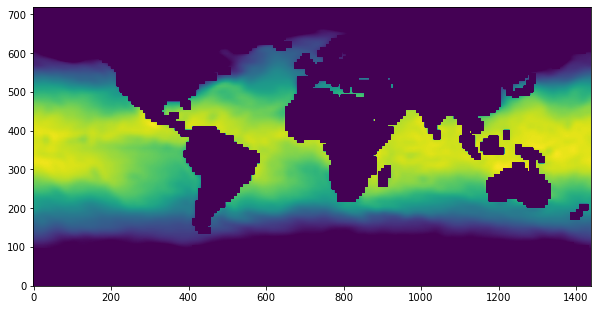

In [14]:
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(data, origin="lower", vmin=0, vmax=30)

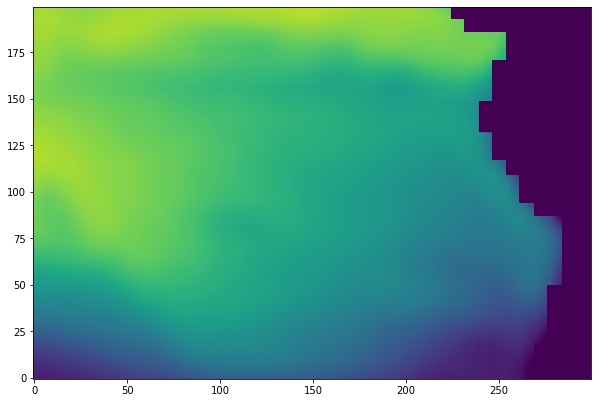

In [15]:
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(data[200:400, 150:450], origin="lower", vmin=11, vmax=30)  

In [16]:
non_fill = data[data != fill_value]

In [17]:
histo = np.histogram(non_fill, bins=1000)

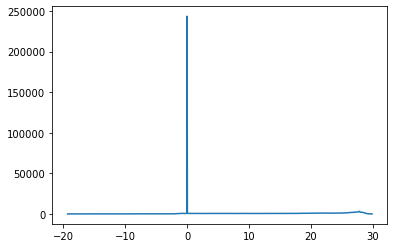

In [18]:
plt.plot(histo[1][:-1], histo[0])

In [20]:
start_index = 0
end_index = 7850   # set end_index to value between 1 an 7850
%time tseries = tair2m[start_index:end_index, 350, 600]

CPU times: user 5 ms, sys: 423 µs, total: 5.42 ms
Wall time: 255 ms


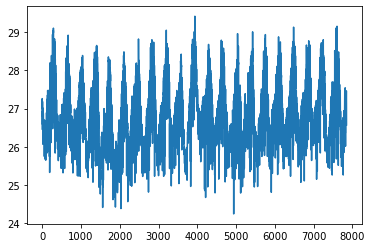

In [21]:
x = range(start_index,end_index)
plt.plot(x, tseries)

In [22]:
# calculate mean, median, stddev, min, max
end_index = 100
summaries = np.zeros((end_index-start_index, 5))
def calc_summaries():
    for i in range(start_index, end_index):
        data = tair2m[i, :,:]
        non_fill = data[data != fill_value]
        summary = (np.mean(non_fill), np.median(non_fill), np.std(non_fill), np.min(non_fill), np.max(non_fill))
        summaries[i] = summary
%time calc_summaries()

CPU times: user 2.84 s, sys: 296 ms, total: 3.13 s
Wall time: 25.9 s


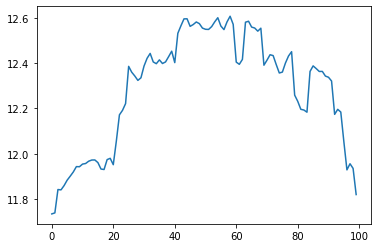

In [23]:
x = range(start_index,end_index)
plt.plot(x, summaries[:,0])